# Image RAG with CLIP


## 1. Download Wikipedia Images


In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

from pathlib import Path
IMAGE_PATH = Path("images")

In [3]:
import wikipedia
import urllib.request
from pathlib import Path

image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Salesforce",
    "Tesla",
    "Cluade Monet", 
    "San Francisco",
    "Violin", 
    "Mount Fuji",
    "iPhone"
]

if not IMAGE_PATH.exists():
    Path.mkdir(IMAGE_PATH)

In [4]:
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(IMAGE_PATH / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, IMAGE_PATH / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        continue

Salesforce
Tesla
Cluade Monet
San Francisco
Violin
Mount Fuji
iPhone


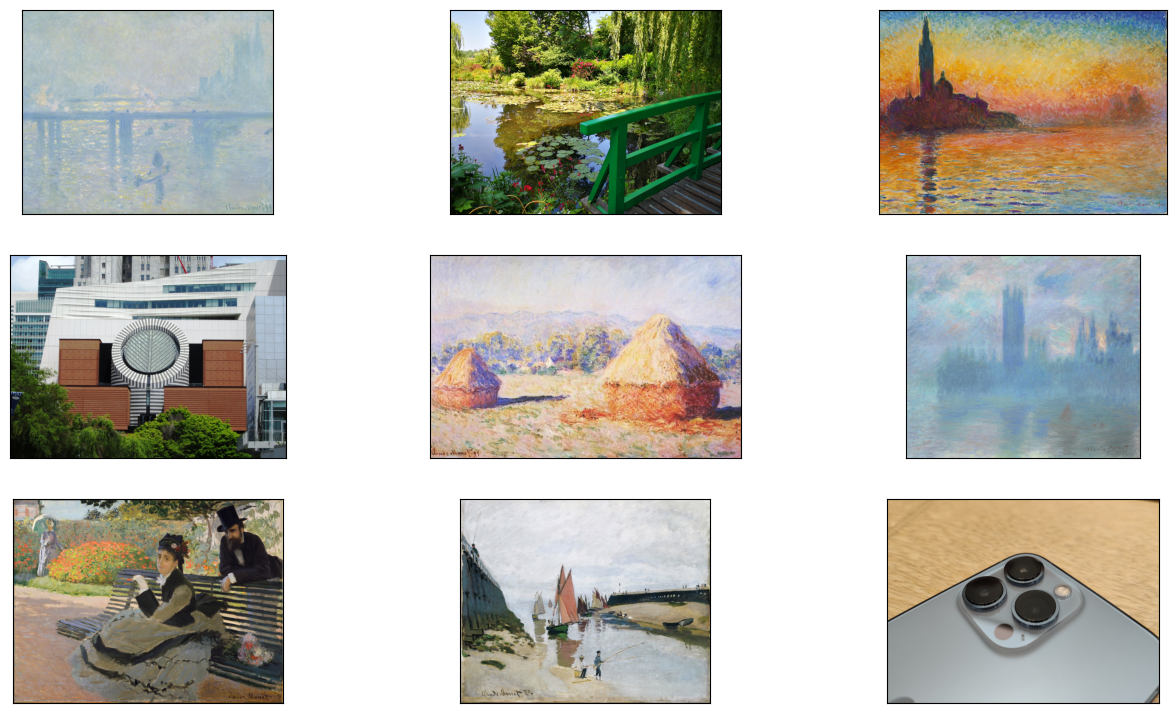

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir(IMAGE_PATH):
    image_paths.append(str(os.path.join(IMAGE_PATH, img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

plot_images(image_paths)

## Build Multi-Modal Index


In [6]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader

# do a search on "local docker qdrant install"
TEXT_COLLECTION_NAME = "wiki_text"
IMAGE_COLLECTION_NAME = "wiki_image"
DEFAULT_QDRANT_PORT = "6333"
QDRANT_URL = "http://localhost:6333" 
# os.environ.get("QDRANT_LOCAL_URL")
QDRANT_API_KEY = os.environ.get("QDRANT_API_KEY")
q_client = qdrant_client.QdrantClient(url=QDRANT_URL, port=DEFAULT_QDRANT_PORT)